# Benchmarks

## Initialize

In [1]:
import os
import math
import pathlib
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.feather as feather
from tqdm.auto import tqdm
from IPython.display import clear_output

import warnings
from lifelines.utils import CensoringType
from lifelines.utils import concordance_index

In [2]:
# import ray
# ray.shutdown()

In [3]:
base_path = "/home/jakobs"

project_path = f"{base_path}/data"

experiment = '230629'
experiment_path = f"{project_path}/{experiment}"
pathlib.Path(experiment_path).mkdir(parents=True, exist_ok=True)

partitions = [i for i in range(10)]

In [4]:
endpoints_md = pd.read_feather(f"{base_path}/data/endpoints_epic_md.feather").set_index("endpoint")
endpoints = endpoints_md.index.to_list()

In [5]:
data_baseline = pd.read_feather(f"{base_path}/data/data_baseline_230321.feather")
data_baseline

,eid,ml_glaucoma_gradability_grad_l,ml_glaucoma_gradability_grad_r,ml_glaucoma_gradability_wdiff_l,ml_glaucoma_gradability_wdiff_r,age3,alcohol3,cigstat3,recruitment_date,systol3,diastol3,mi3,cva3,sex,bmi3,cholesterol3,triglyceride3,hdl3,ldl3
0,RID00001,0.955591,0.760914,0.043725,0.226360,86.127310,2.0,3.0,2007-08-07,138.0,72.5,0.0,0.0,2,33.455266,6.4,1.5,1.53,4.27
1,RID00002,0.986005,0.943931,0.013981,0.054606,70.505133,2.0,3.0,2010-07-08,105.5,68.5,0.0,0.0,2,25.593164,3.9,2.3,1.50,1.40
2,RID00003,0.990022,0.981540,0.009343,0.017813,64.577687,1.0,2.0,2007-04-26,128.5,78.5,0.0,0.0,2,25.372781,3.9,2.1,1.52,1.48
3,RID00004,0.894128,0.945897,0.103611,0.052175,66.740589,1.0,3.0,2006-07-31,154.5,87.5,0.0,0.0,2,27.070312,6.0,1.3,1.80,3.70
4,RID00006,0.940763,0.959411,0.055711,0.039147,72.366872,2.0,3.0,2007-07-10,138.0,66.5,0.0,0.0,2,26.189022,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7243,RID07407,0.940662,0.962702,0.058866,0.037013,73.675565,1.0,3.0,2006-11-03,132.0,73.0,0.0,0.0,1,25.032679,3.9,1.2,1.39,2.01
7244,RID07408,0.719619,0.637359,0.276180,0.355266,64.533881,1.0,3.0,2008-12-18,147.5,81.0,0.0,0.0,2,27.957894,6.8,1.0,1.76,4.64
7245,RID07409,0.635806,0.926931,0.342445,0.072251,82.475017,NaN,NaN,2007-09-27,144.5,80.0,0.0,0.0,2,26.053959,6.4,1.5,1.95,3.85
7246,RID07410,0.861651,0.054378,0.133713,0.028145,82.568104,1.0,2.0,2010-07-21,109.5,63.5,0.0,0.0,1,29.726252,NaN,NaN,NaN,NaN


In [6]:
import ray
# ray start --head --port=6379 --num-cpus 64
ray.init(num_cpus=24, include_dashboard=False)#, dashboard_port=24762, dashboard_host="0.0.0.0", include_dashboard=True)#, webui_url="0.0.0.0"))
#ray.init(address='auto')

2023-06-30 09:59:50,505	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.11.0
Ray version:,2.3.0


In [7]:
data_covariates = pd.read_feather(f"{experiment_path}/data_covariates_full.feather").set_index("eid")

In [8]:
# data_covariates = data_covariates[['age', 'sex', 'ethnic_background']]

In [9]:
AgeSex = ["age", "sex"]

SCORE2 = [
    "age", 
    "sex",
    "smoking_status", # current smoker
    "systolic_blood_pressure",
    "cholesterol",
    "hdl_cholesterol",

] 

ASCVD = [
    "age", 
    "sex",
    #"ethnic_background",
    "smoking_status", # current smoker
    "diabetes", # diabetes
    #"antihypertensives", 
    "systolic_blood_pressure",
    "cholesterol",
    "hdl_cholesterol",
] 


# assert, that all variables are available
covariates_scores = sorted(list(set(AgeSex + SCORE2 + ASCVD)))
if not set(covariates_scores).issubset(data_covariates.columns.to_list()):
    print("Not all required covariates are prepared!", list(set(covariates_scores).difference(data_covariates.columns.to_list())))
else:
    print("Success, all required covariates are prepared!")
    data_covariates = data_covariates[covariates_scores]

Success, all required covariates are prepared!


In [10]:
variables_cont = data_covariates.select_dtypes(include=["int32", "float32", "float64"]).columns.to_list()#dtypes.to_frame().rename(columns={0:"dtype"}).query("dtype!='bool'")
variables_cat = data_covariates.select_dtypes(include=["category"]).columns.to_list()
variables_bool = data_covariates.select_dtypes(include=["bool"]).columns.to_list()#dtypes.to_frame().rename(columns={0:"dtype"}).query("dtype!='bool'")
print("Cont: ", variables_cont)
print("Cat: ", variables_cat)
print("Bool: ", variables_bool)

variables_to_norm = variables_cont + endpoints
#variables_to_norm

Cont:  ['age', 'cholesterol', 'diabetes', 'hdl_cholesterol', 'systolic_blood_pressure']
Cat:  ['sex', 'smoking_status']
Bool:  []


In [11]:
in_path = pathlib.Path(f"{experiment_path}/loghs")
in_path.mkdir(parents=True, exist_ok=True)

out_path = f"{experiment_path}/coxph/input"
pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)

In [12]:
models = [f.name for f in in_path.iterdir() if f.is_dir() and "ipynb_checkpoints" not in str(f)]
for model in models:
    pathlib.Path(os.path.join(out_path, model)).mkdir(parents=True, exist_ok=True)
    for p in partitions:
        pathlib.Path(os.path.join(out_path, model, str(p))).mkdir(parents=True, exist_ok=True)
models

['RetinaUKB']

In [13]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import miceforest
import pickle
import zstandard

def read_merge_data(fp_in, split, data_covariates, variables_to_prepare):
    temp = pd.read_feather(f"{fp_in}/{split}.feather").set_index("eid")
    temp["split"] = temp["split"].astype(str)
    temp = temp.merge(data_covariates, left_index=True, right_index=True, how="left")[variables_to_prepare]
    return temp   

def load_pickle(fp):
    with open(fp, "rb") as fh:
        dctx = zstandard.ZstdDecompressor()
        with dctx.stream_reader(fh) as decompressor:
            data = pickle.loads(decompressor.read())
    return data
    
def save_pickle(data, data_path):
    pathlib.Path(data_path).parent.mkdir(parents=True, exist_ok=True)
    with open(data_path, "wb") as fh:
        cctx = zstandard.ZstdCompressor()
        with cctx.stream_writer(fh) as compressor:
            compressor.write(pickle.dumps(data, protocol=pickle.HIGHEST_PROTOCOL))
            
def get_variable_schema(data):
    
    missing = data.columns[data.isna().any()].to_list()
    
    print(missing)
    
    variable_schema = {}
    for m in missing:
        variable_schema[m] = [x for x in data.columns if x != m]
    
    return variable_schema

def tune_imputer(data):
    
    variable_schema = get_variable_schema(data)
        
    kernel = miceforest.ImputationKernel(data, datasets=1, random_state=42)#, train_nonmissing=True)
    
    best_hps, losses = kernel.tune_parameters(dataset=0, n_jobs=96, optimization_steps=5, verbose=True) # add bootstrrapping! 
  
    return best_hps

def get_imputer_hps(data_covariates, variables_to_prepare, model, partition, samples):

    fp_in = f"{in_path}/{model}/{partition}"
    fp_out = f"{out_path}/{model}/"
    pathlib.Path(fp_out).mkdir(parents=True, exist_ok=True)
    
    temp = read_merge_data(fp_in, "train", data_covariates, variables_to_prepare).sample(samples, replace=False)

    print("tune hps")
    best_hps = tune_imputer(temp)
    save_pickle(best_hps, f"{fp_out}/imputer_best_hps.p")
    
    return best_hps

def fit_imputer(data, best_hps, fp_out):
    
    variable_schema = get_variable_schema(data)
    print(variable_schema)
        
    kernel = miceforest.ImputationKernel(data, datasets=1, random_state=42)#, train_nonmissing=True)

    # Run the MICE algorithm for 3 iterations
    kernel.mice(3, n_jobs=96, variable_parameters=best_hps, verbose=True)
    
    kernel.plot_imputed_distributions(wspace=0.3,hspace=0.3)
    
    plt.savefig(f"{fp_out}/imputer_distributions.pdf", bbox_inches='tight')
    
    return kernel
    
@ray.remote
def scale_encode_save_feather(partition, split, temp_df, scaler, variables_cont, variables_cat, fp_out):
    print(partition, split, f"scale {split}")
    temp_df[variables_cont] = scaler.transform(temp_df[variables_cont].values)

    print(partition, split, f"onehotencode {split}")
    temp_df = pd.get_dummies(temp_df, columns=variables_cat, prefix=variables_cat)

    # save imputed and standardized file
    print(partition, split, f"save {split}")
    temp_df.reset_index(drop=False).to_feather(f"{fp_out}/{split}.feather")
    

def impute_norm_variables(data_covariates, model, partition, variables_to_prepare, variables_cont, variables_cat, samples):

    fp_in = f"{in_path}/{model}/{partition}"
    fp_out = f"{out_path}/{model}/{partition}"
      
    if pathlib.Path(fp_in).is_dir():
        if not pathlib.Path(fp_out).is_dir():
            pathlib.Path(fp_out).mkdir(parents=True, exist_ok=True)
            
    for split in tqdm(["train", "test"]):
        
        print(partition, split, "read and merge data")
        temp = read_merge_data(fp_in, split, data_covariates, variables_to_prepare)
    
        if split=="train": 
            # fit and save imputer
            print(partition, split, "fit imputer")
            print(partition, split, "fit imputer: load hps")
            best_hps = load_pickle(f"{out_path}/{model}/imputer_best_hps.p")
            print(partition, split, "fit imputer: fit imputer")
            imputer = fit_imputer(temp.sample(samples), best_hps, fp_out)
            print(partition, split, "fit imputer: save imputer")
            save_pickle(imputer, f"{fp_out}/imputer.p")
            
            # check imputer and log results
            print(partition, split, "check imputer: plot distributions")
            print(imputer.plot_imputed_distributions(wspace=0.3,hspace=0.3))
            #plt.savefig(f"{fp_out}/imputed_dists.png")
            
        # apply imputer and scaler
        print(partition, split, f"impute {split}")
        try:
            temp = imputer.impute_new_data(new_data=temp, verbose=True).complete_data(0)
        except AssertionError as e:
            print(f"ERROR {partition} {split}")
            print(e)
            temp.reset_index().to_feather(f"error_{partition}_{split}.feather")
        
        if split=="train": 
            
            # fit and save standardscaler
            print(partition, split, "fit scaler")
            scaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(temp[variables_cont].values)
            save_pickle(scaler, f"{fp_out}/scaler.p")
            
        scale_encode_save_feather.remote(partition, split, temp, scaler, variables_cont, variables_cat, fp_out)
        
    return True

In [14]:
variables_to_prepare = covariates_scores + endpoints
get_imputer_hps(data_covariates, variables_to_prepare, models[0], partitions[0], samples=6500)

tune hps
['cholesterol', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Initialized logger with name tune: 5
systolic_blood_pressure | 0 - 1 - 2 - 3 - 4 - 
smoking_status | 0 - 1 - 2 - 3 - 4 - 
hdl_cholesterol | 0 - 1 - 2 - 3 - 4 - 
cholesterol | 0 - 1 - 2 - 3 - 4 - 


{6: {'boosting': 'gbdt',
  'num_iterations': 133,
  'max_depth': 8,
  'num_leaves': 14,
  'min_data_in_leaf': 280,
  'min_sum_hessian_in_leaf': 0.1,
  'min_gain_to_split': 0.0,
  'bagging_fraction': 0.3995342073212359,
  'feature_fraction': 1.0,
  'feature_fraction_bynode': 0.7574942231283713,
  'bagging_freq': 1,
  'verbosity': -1,
  'objective': 'regression',
  'learning_rate': 0.02,
  'cat_smooth': 17.34294018508346,
  'n_jobs': 96},
 5: {'boosting': 'gbdt',
  'num_iterations': 120,
  'max_depth': 8,
  'num_leaves': 5,
  'min_data_in_leaf': 149,
  'min_sum_hessian_in_leaf': 0.1,
  'min_gain_to_split': 0.0,
  'bagging_fraction': 0.7500273115537597,
  'feature_fraction': 1.0,
  'feature_fraction_bynode': 0.748032882891467,
  'bagging_freq': 1,
  'verbosity': -1,
  'objective': 'multiclass',
  'num_class': 3,
  'learning_rate': 0.02,
  'cat_smooth': 16.028690822132432,
  'n_jobs': 96},
 3: {'boosting': 'gbdt',
  'num_iterations': 141,
  'max_depth': 8,
  'num_leaves': 15,
  'min_data_i

In [15]:
def norm_logh_and_extra(data_covariates, variables_to_prepare, variables_cont, variables_cat, samples):
    
    print(f"Tune and fit imputation with {samples} samples")
    
    hps_path = f"{out_path}/{models[0]}/imputer_best_hps.p"
    if not pathlib.Path(hps_path).is_file():
        print(f"No HPs found, estimating new HPs...")
        get_imputer_hps(data_covariates, models[0], partitions[0], samples)
    else:
        print(f"Use {hps_path}")

    progress = []
    for model in models:
        for partition in tqdm(partitions):
            progress.append(impute_norm_variables(data_covariates, model, partition, variables_to_prepare, variables_cont, variables_cat, samples))
    #[ray.get(s) for s in tqdm(progress)]

Tune and fit imputation with 6491 samples
Use /home/jakobs/data/230629/coxph/input/RetinaUKB/imputer_best_hps.p


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 train read and merge data
0 train fit imputer
0 train fit imputer: load hps
0 train fit imputer: fit imputer
['cholesterol', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
{'cholesterol': ['age', 'diabetes', 'hdl_cholesterol', 'sex', 'smoking_status', 'systolic_blood_pressure', 'OMOP_4306655', 'phecode_052', 'phecode_052-3', 'phecode_052-32', 'phecode_061', 'phecode_070', 'phecode_089', 'phecode_089-1', 'phecode_089-2', 'phecode_089-3', 'phecode_092', 'phecode_092-2', 'phecode_098', 'phecode_100', 'phecode_101', 'phecode_101-1', 'phecode_101-2', 'phecode_101-4', 'phecode_101-41', 'phecode_101-42', 'phecode_101-8', 'phecode_102', 'phecode_102-1', 'phecode_103', 'phecode_103-1', 'phecode_103-3', 'phecode_104', 'phecode_105', 'phecode_106', 'phecode_106-2', 'phecode_106-21', 'phecode_106-3', 'phecode_107', 'phecode_107-2', 'phecode_108', 'phecode_108-4', 'phecode_108-41', 'phecode_108-5', 'phecode_112', 'phecode_116', 'phecode_116-1', 'phecode_120', 'phecode_120-1', 'ph

  0%|          | 0/2 [00:00<?, ?it/s]

1 train read and merge data
1 train fit imputer
1 train fit imputer: load hps
1 train fit imputer: fit imputer
['cholesterol', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
{'cholesterol': ['age', 'diabetes', 'hdl_cholesterol', 'sex', 'smoking_status', 'systolic_blood_pressure', 'OMOP_4306655', 'phecode_052', 'phecode_052-3', 'phecode_052-32', 'phecode_061', 'phecode_070', 'phecode_089', 'phecode_089-1', 'phecode_089-2', 'phecode_089-3', 'phecode_092', 'phecode_092-2', 'phecode_098', 'phecode_100', 'phecode_101', 'phecode_101-1', 'phecode_101-2', 'phecode_101-4', 'phecode_101-41', 'phecode_101-42', 'phecode_101-8', 'phecode_102', 'phecode_102-1', 'phecode_103', 'phecode_103-1', 'phecode_103-3', 'phecode_104', 'phecode_105', 'phecode_106', 'phecode_106-2', 'phecode_106-21', 'phecode_106-3', 'phecode_107', 'phecode_107-2', 'phecode_108', 'phecode_108-4', 'phecode_108-41', 'phecode_108-5', 'phecode_112', 'phecode_116', 'phecode_116-1', 'phecode_120', 'phecode_120-1', 'ph

  0%|          | 0/2 [00:00<?, ?it/s]

2 train read and merge data
2 train fit imputer
2 train fit imputer: load hps
2 train fit imputer: fit imputer
['cholesterol', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
{'cholesterol': ['age', 'diabetes', 'hdl_cholesterol', 'sex', 'smoking_status', 'systolic_blood_pressure', 'OMOP_4306655', 'phecode_052', 'phecode_052-3', 'phecode_052-32', 'phecode_061', 'phecode_070', 'phecode_089', 'phecode_089-1', 'phecode_089-2', 'phecode_089-3', 'phecode_092', 'phecode_092-2', 'phecode_098', 'phecode_100', 'phecode_101', 'phecode_101-1', 'phecode_101-2', 'phecode_101-4', 'phecode_101-41', 'phecode_101-42', 'phecode_101-8', 'phecode_102', 'phecode_102-1', 'phecode_103', 'phecode_103-1', 'phecode_103-3', 'phecode_104', 'phecode_105', 'phecode_106', 'phecode_106-2', 'phecode_106-21', 'phecode_106-3', 'phecode_107', 'phecode_107-2', 'phecode_108', 'phecode_108-4', 'phecode_108-41', 'phecode_108-5', 'phecode_112', 'phecode_116', 'phecode_116-1', 'phecode_120', 'phecode_120-1', 'ph

  0%|          | 0/2 [00:00<?, ?it/s]

3 train read and merge data
3 train fit imputer
3 train fit imputer: load hps
3 train fit imputer: fit imputer
['cholesterol', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
{'cholesterol': ['age', 'diabetes', 'hdl_cholesterol', 'sex', 'smoking_status', 'systolic_blood_pressure', 'OMOP_4306655', 'phecode_052', 'phecode_052-3', 'phecode_052-32', 'phecode_061', 'phecode_070', 'phecode_089', 'phecode_089-1', 'phecode_089-2', 'phecode_089-3', 'phecode_092', 'phecode_092-2', 'phecode_098', 'phecode_100', 'phecode_101', 'phecode_101-1', 'phecode_101-2', 'phecode_101-4', 'phecode_101-41', 'phecode_101-42', 'phecode_101-8', 'phecode_102', 'phecode_102-1', 'phecode_103', 'phecode_103-1', 'phecode_103-3', 'phecode_104', 'phecode_105', 'phecode_106', 'phecode_106-2', 'phecode_106-21', 'phecode_106-3', 'phecode_107', 'phecode_107-2', 'phecode_108', 'phecode_108-4', 'phecode_108-41', 'phecode_108-5', 'phecode_112', 'phecode_116', 'phecode_116-1', 'phecode_120', 'phecode_120-1', 'ph

  0%|          | 0/2 [00:00<?, ?it/s]

4 train read and merge data
(scale_encode_save_feather pid=30727) 3 test scale test
4 train fit imputer
4 train fit imputer: load hps
4 train fit imputer: fit imputer
['cholesterol', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
{'cholesterol': ['age', 'diabetes', 'hdl_cholesterol', 'sex', 'smoking_status', 'systolic_blood_pressure', 'OMOP_4306655', 'phecode_052', 'phecode_052-3', 'phecode_052-32', 'phecode_061', 'phecode_070', 'phecode_089', 'phecode_089-1', 'phecode_089-2', 'phecode_089-3', 'phecode_092', 'phecode_092-2', 'phecode_098', 'phecode_100', 'phecode_101', 'phecode_101-1', 'phecode_101-2', 'phecode_101-4', 'phecode_101-41', 'phecode_101-42', 'phecode_101-8', 'phecode_102', 'phecode_102-1', 'phecode_103', 'phecode_103-1', 'phecode_103-3', 'phecode_104', 'phecode_105', 'phecode_106', 'phecode_106-2', 'phecode_106-21', 'phecode_106-3', 'phecode_107', 'phecode_107-2', 'phecode_108', 'phecode_108-4', 'phecode_108-41', 'phecode_108-5', 'phecode_112', 'phecode_11

  0%|          | 0/2 [00:00<?, ?it/s]

5 train read and merge data
5 train fit imputer
5 train fit imputer: load hps
5 train fit imputer: fit imputer
['cholesterol', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
{'cholesterol': ['age', 'diabetes', 'hdl_cholesterol', 'sex', 'smoking_status', 'systolic_blood_pressure', 'OMOP_4306655', 'phecode_052', 'phecode_052-3', 'phecode_052-32', 'phecode_061', 'phecode_070', 'phecode_089', 'phecode_089-1', 'phecode_089-2', 'phecode_089-3', 'phecode_092', 'phecode_092-2', 'phecode_098', 'phecode_100', 'phecode_101', 'phecode_101-1', 'phecode_101-2', 'phecode_101-4', 'phecode_101-41', 'phecode_101-42', 'phecode_101-8', 'phecode_102', 'phecode_102-1', 'phecode_103', 'phecode_103-1', 'phecode_103-3', 'phecode_104', 'phecode_105', 'phecode_106', 'phecode_106-2', 'phecode_106-21', 'phecode_106-3', 'phecode_107', 'phecode_107-2', 'phecode_108', 'phecode_108-4', 'phecode_108-41', 'phecode_108-5', 'phecode_112', 'phecode_116', 'phecode_116-1', 'phecode_120', 'phecode_120-1', 'ph

  0%|          | 0/2 [00:00<?, ?it/s]

6 train read and merge data
6 train fit imputer
6 train fit imputer: load hps
6 train fit imputer: fit imputer
['cholesterol', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
{'cholesterol': ['age', 'diabetes', 'hdl_cholesterol', 'sex', 'smoking_status', 'systolic_blood_pressure', 'OMOP_4306655', 'phecode_052', 'phecode_052-3', 'phecode_052-32', 'phecode_061', 'phecode_070', 'phecode_089', 'phecode_089-1', 'phecode_089-2', 'phecode_089-3', 'phecode_092', 'phecode_092-2', 'phecode_098', 'phecode_100', 'phecode_101', 'phecode_101-1', 'phecode_101-2', 'phecode_101-4', 'phecode_101-41', 'phecode_101-42', 'phecode_101-8', 'phecode_102', 'phecode_102-1', 'phecode_103', 'phecode_103-1', 'phecode_103-3', 'phecode_104', 'phecode_105', 'phecode_106', 'phecode_106-2', 'phecode_106-21', 'phecode_106-3', 'phecode_107', 'phecode_107-2', 'phecode_108', 'phecode_108-4', 'phecode_108-41', 'phecode_108-5', 'phecode_112', 'phecode_116', 'phecode_116-1', 'phecode_120', 'phecode_120-1', 'ph

  0%|          | 0/2 [00:00<?, ?it/s]

7 train read and merge data
7 train fit imputer
7 train fit imputer: load hps
7 train fit imputer: fit imputer
['cholesterol', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
{'cholesterol': ['age', 'diabetes', 'hdl_cholesterol', 'sex', 'smoking_status', 'systolic_blood_pressure', 'OMOP_4306655', 'phecode_052', 'phecode_052-3', 'phecode_052-32', 'phecode_061', 'phecode_070', 'phecode_089', 'phecode_089-1', 'phecode_089-2', 'phecode_089-3', 'phecode_092', 'phecode_092-2', 'phecode_098', 'phecode_100', 'phecode_101', 'phecode_101-1', 'phecode_101-2', 'phecode_101-4', 'phecode_101-41', 'phecode_101-42', 'phecode_101-8', 'phecode_102', 'phecode_102-1', 'phecode_103', 'phecode_103-1', 'phecode_103-3', 'phecode_104', 'phecode_105', 'phecode_106', 'phecode_106-2', 'phecode_106-21', 'phecode_106-3', 'phecode_107', 'phecode_107-2', 'phecode_108', 'phecode_108-4', 'phecode_108-41', 'phecode_108-5', 'phecode_112', 'phecode_116', 'phecode_116-1', 'phecode_120', 'phecode_120-1', 'ph

  0%|          | 0/2 [00:00<?, ?it/s]

8 train read and merge data
8 train fit imputer
8 train fit imputer: load hps
8 train fit imputer: fit imputer
['cholesterol', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
{'cholesterol': ['age', 'diabetes', 'hdl_cholesterol', 'sex', 'smoking_status', 'systolic_blood_pressure', 'OMOP_4306655', 'phecode_052', 'phecode_052-3', 'phecode_052-32', 'phecode_061', 'phecode_070', 'phecode_089', 'phecode_089-1', 'phecode_089-2', 'phecode_089-3', 'phecode_092', 'phecode_092-2', 'phecode_098', 'phecode_100', 'phecode_101', 'phecode_101-1', 'phecode_101-2', 'phecode_101-4', 'phecode_101-41', 'phecode_101-42', 'phecode_101-8', 'phecode_102', 'phecode_102-1', 'phecode_103', 'phecode_103-1', 'phecode_103-3', 'phecode_104', 'phecode_105', 'phecode_106', 'phecode_106-2', 'phecode_106-21', 'phecode_106-3', 'phecode_107', 'phecode_107-2', 'phecode_108', 'phecode_108-4', 'phecode_108-41', 'phecode_108-5', 'phecode_112', 'phecode_116', 'phecode_116-1', 'phecode_120', 'phecode_120-1', 'ph

  0%|          | 0/2 [00:00<?, ?it/s]

9 train read and merge data
9 train fit imputer
9 train fit imputer: load hps
9 train fit imputer: fit imputer
['cholesterol', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
{'cholesterol': ['age', 'diabetes', 'hdl_cholesterol', 'sex', 'smoking_status', 'systolic_blood_pressure', 'OMOP_4306655', 'phecode_052', 'phecode_052-3', 'phecode_052-32', 'phecode_061', 'phecode_070', 'phecode_089', 'phecode_089-1', 'phecode_089-2', 'phecode_089-3', 'phecode_092', 'phecode_092-2', 'phecode_098', 'phecode_100', 'phecode_101', 'phecode_101-1', 'phecode_101-2', 'phecode_101-4', 'phecode_101-41', 'phecode_101-42', 'phecode_101-8', 'phecode_102', 'phecode_102-1', 'phecode_103', 'phecode_103-1', 'phecode_103-3', 'phecode_104', 'phecode_105', 'phecode_106', 'phecode_106-2', 'phecode_106-21', 'phecode_106-3', 'phecode_107', 'phecode_107-2', 'phecode_108', 'phecode_108-4', 'phecode_108-41', 'phecode_108-5', 'phecode_112', 'phecode_116', 'phecode_116-1', 'phecode_120', 'phecode_120-1', 'ph

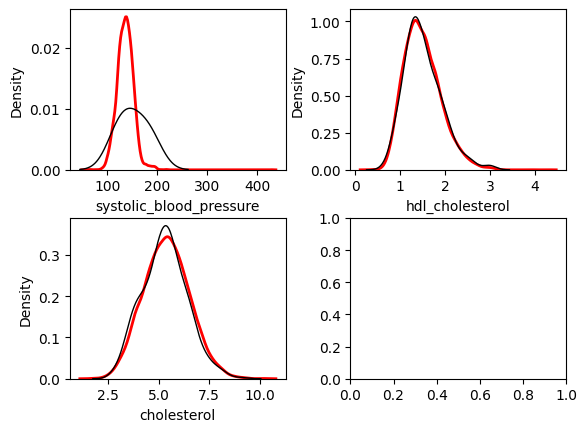

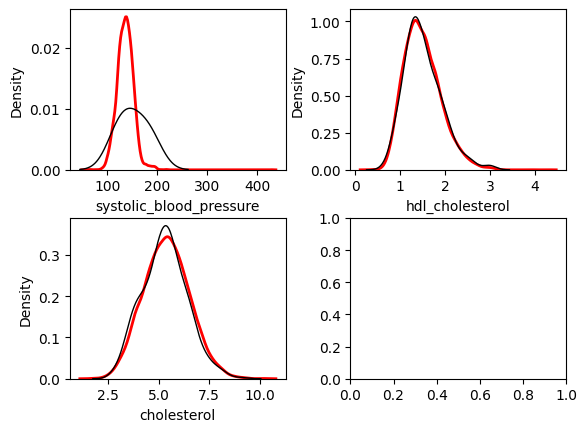

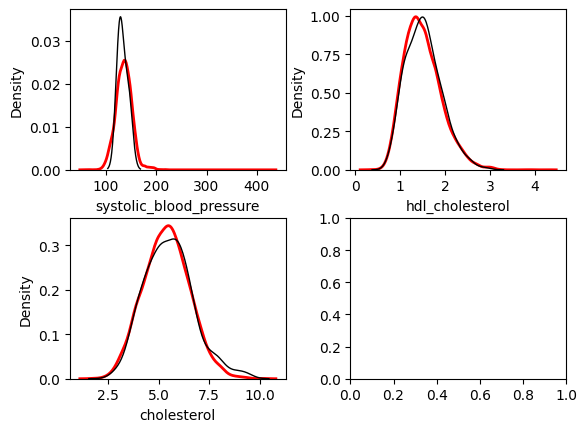

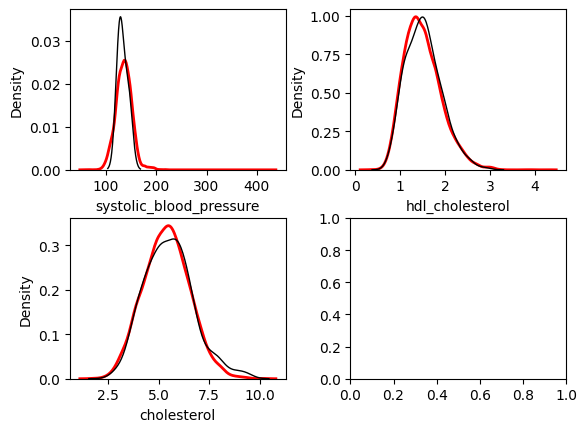

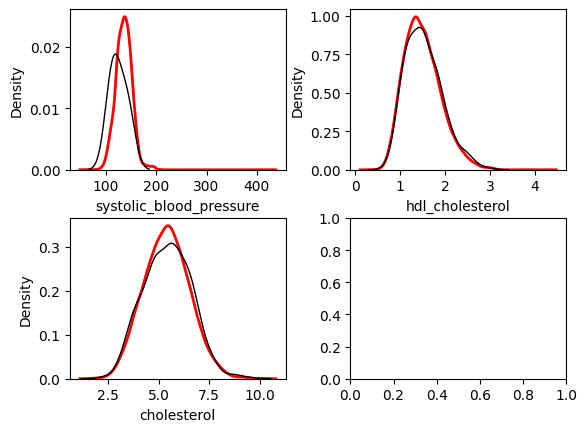

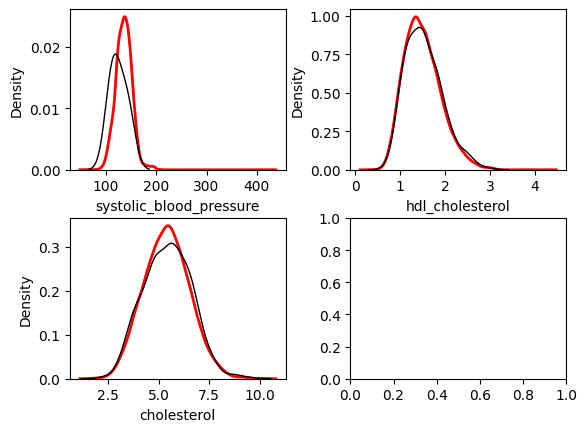

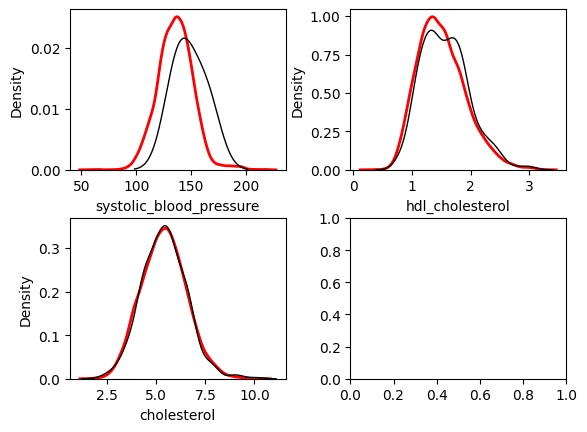

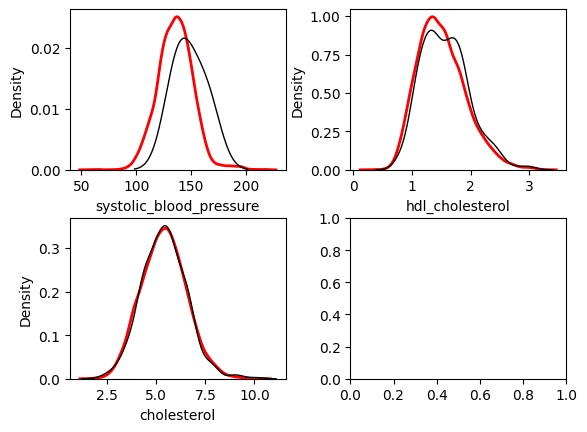

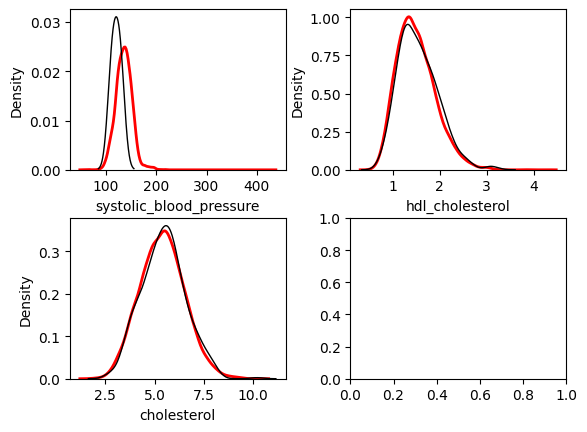

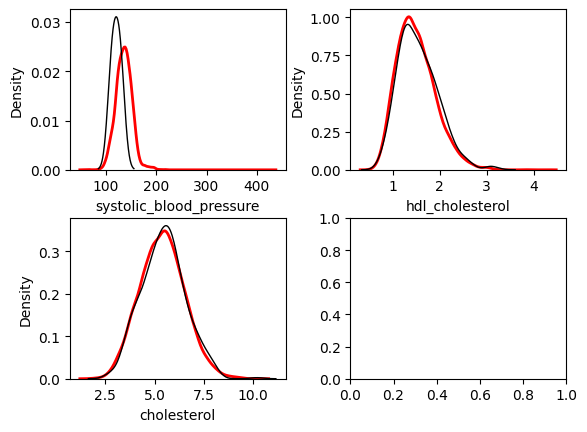

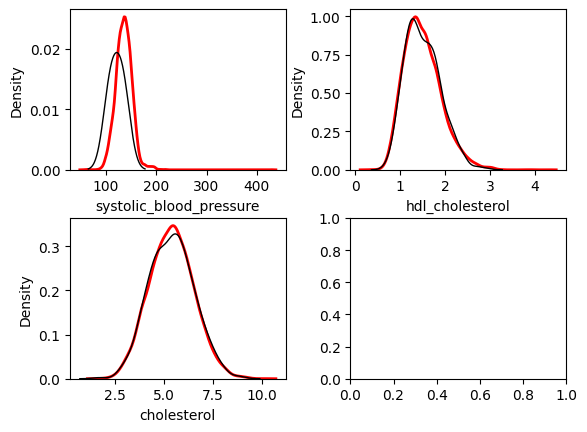

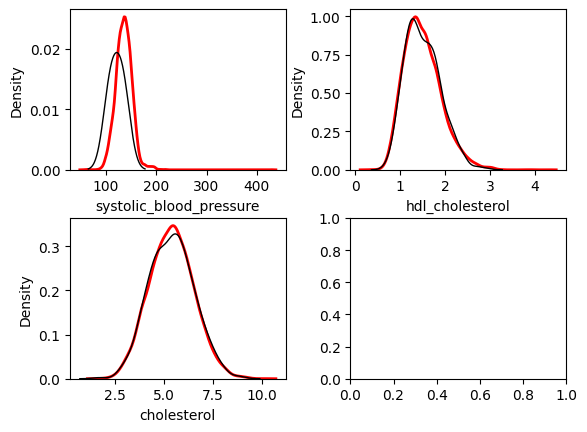

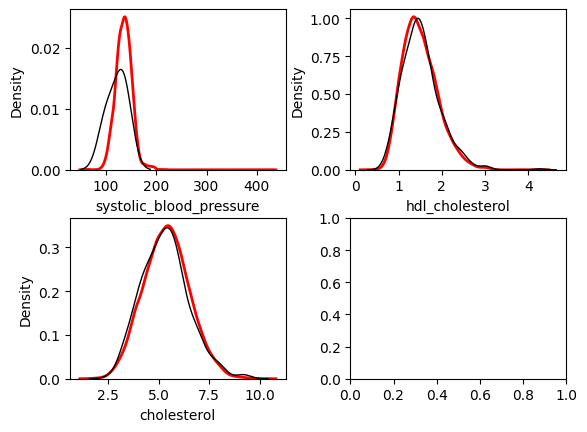

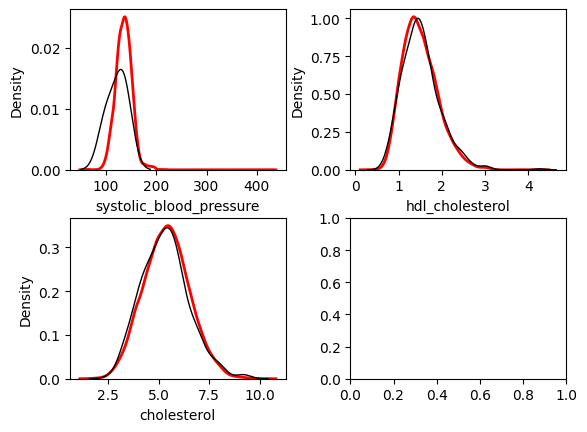

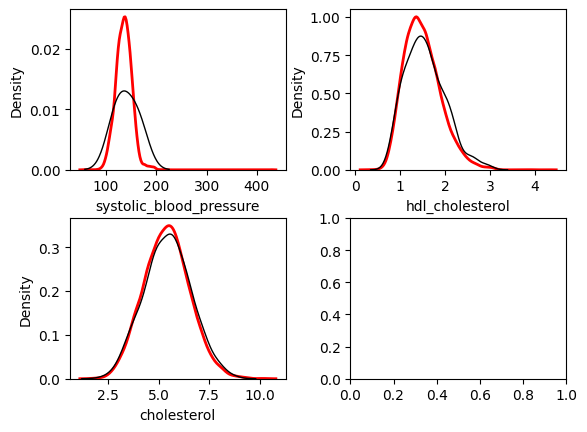

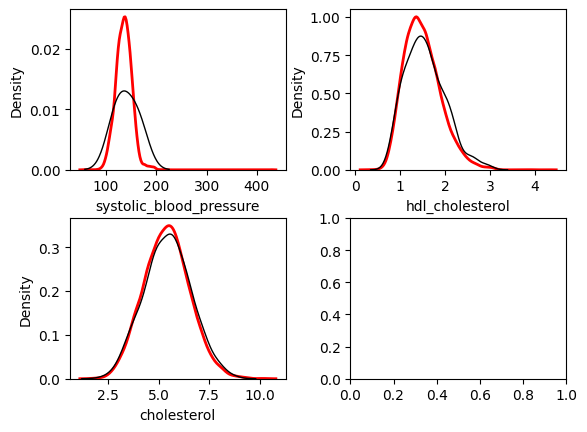

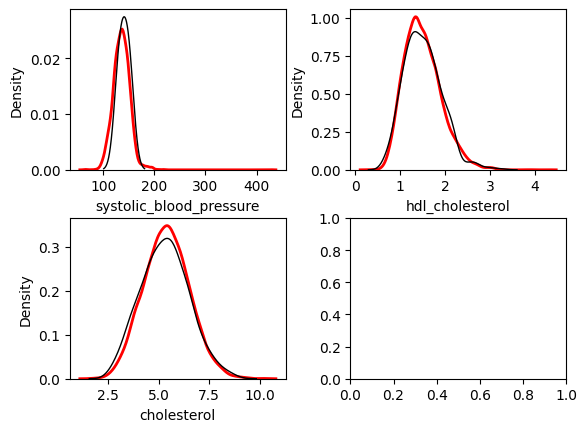

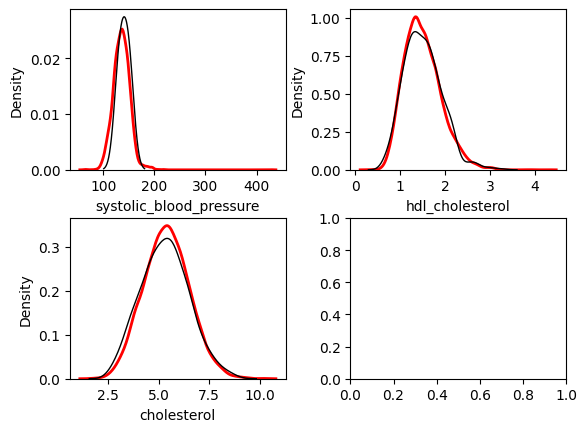

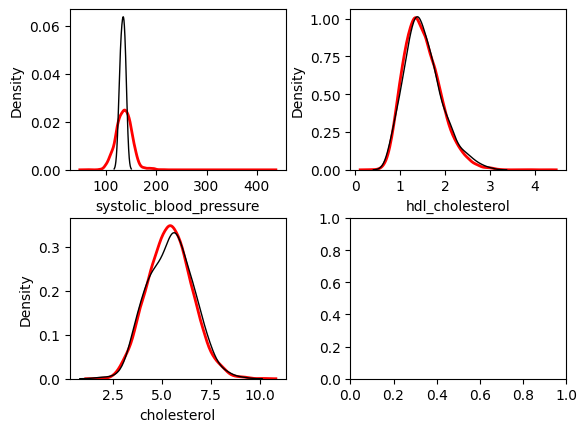

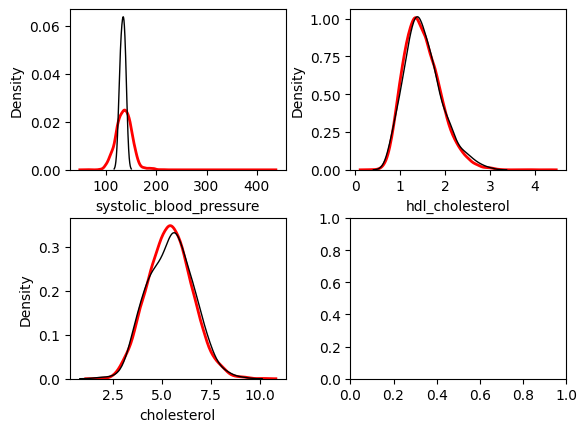

In [16]:
variables_to_prepare = covariates_scores + endpoints
norm_logh_and_extra(data_covariates, variables_to_prepare, variables_cont, variables_cat, 6491)